<a href="https://colab.research.google.com/github/gargarchit/PATE_Analysis/blob/master/Classification_of_MNIST_Digits_using_Differential_Privacy_and_performing_PATE_analysis_on_that_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>1. Loading MNIST Data</h2> 

In [0]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])]) #Grey Scale Image
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  #private data
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  #public data

In [0]:
from torch.utils.data import Subset
num_teachers = 100

teacher_loaders = []  #list of dataloaders

data_size = len(mnist_trainset) # num_teachers

for i in range(num_teachers):
    
    indices = list(range(i*data_size, (i+1) *data_size))
   
    subset_data = Subset(mnist_trainset, indices)
    
    loader = torch.utils.data.DataLoader(subset_data, batch_size=64, num_workers=2)
    teacher_loaders.append(loader)


In [0]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

<h2>2. Visualize a Batch of Training Data</h2>

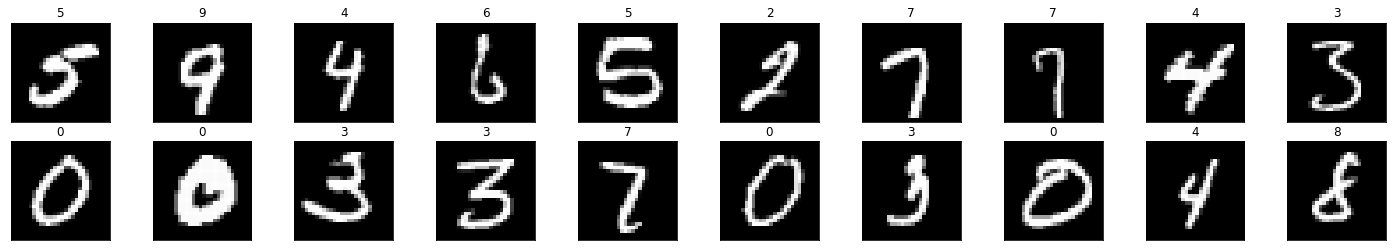

In [34]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

<h2>3. Network Architecture</h2> 

In [0]:
from torch import nn, optim
import torch.nn.functional as F

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        x = F.log_softmax(self.fc4(x), dim=1)

        return x

<h2>4. Training the Nettwork</h2> 

In [42]:
epochs = 30
models = []
for i in range(num_teachers):
  model = Classifier()
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.003)
  dataloader = train_loader[i]
  for e in range(epochs):
    running_loss = 0
    for images, labels in dataloader:
      optimizer.zero_grad()

      log_ps = model(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
  models.append(model)

TypeError: ignored

In [1]:
!pip install tf-encrypted

! URL="https://github.com/openmined/PySyft.git" && FOLDER="PySyft" && if [ ! -d $FOLDER ]; then git clone -b dev --single-branch $URL; else (cd $FOLDER && git pull $URL && cd ..); fi;

!cd PySyft; python setup.py install  > /dev/null

import os
import sys
module_path = os.path.abspath(os.path.join('./PySyft'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
!pip install --upgrade --force-reinstall lz4
!pip install --upgrade --force-reinstall websocket
!pip install --upgrade --force-reinstall websockets
!pip install --upgrade --force-reinstall zstd

     |████████████████████████████████| 1.4MB 5.1MB/s 
     |████████████████████████████████| 276kB 45.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Cloning into 'PySyft'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26853 (delta 11), reused 13 (delta 6), pack-reused 26821
Receiving objects: 100% (26853/26853), 31.66 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (17528/17528), done.
zip_safe flag not set; analyzing archive contents...
zip_safe flag not set; analyzing archive contents...
__pycache__.zstd.cpython-36: module references __file__
     |████████████████████████████████| 389kB 5.1MB/s 
ERROR: syft 0.1.19a1 has requirement msgpack>=0.6.1, but you'll have msgpack 0.

In [0]:
from syft.frameworks.torch.differential_privacy import pate